# This script was used to see how electrodes correlate across subjects. See another from: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006769
#

High CC means phase-locking;

In [1]:
import numpy as np

from gesture.group_analysis.util import get_epoch_and_anat_label
import matplotlib.pyplot as plt
import scipy.io
from gesture.config import *
import h5py
import pandas as pd
from gesture.utils import sub_sf_dict

2024-09-09 11:31:00 - Start Program

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [2]:
filename=meta_dir+'ele_anat_position.npy'
ele = np.load(filename,allow_pickle=True).item()

In [3]:
sid=2
info_dict=sub_sf_dict()
sf=info_dict[str(sid)]

tmin=0
tmax=0.5
#epochs=get_epoch(sid, sf,scaler='no',trigger='EMG',tmin=tmin,tmax=tmax)
epochs=get_epoch_and_anat_label(sid, sf,tmin=tmin,tmax=tmax,trigger='EMG',re_ordered=True,random_shift=False)
#epoch1=epochs['1']# 20 trials. 8001 time points per trial for 8s.
#epoch2=epochs['2']
epoch3=epochs['3'] # simple grasp
total_ch_number=len(epoch3.info.ch_names)
ch_names=epoch3.info['ch_names']
ch_types=epochs.get_channel_types
#epoch4=epochs['4']

### CC within trials from the same subject

Mean cc is low; CC is high only for some channels. It means only few channels resemble to each other, while most of them oscilate differently.

In [4]:
epoch=epoch3.copy().load_data().filter(l_freq=0.1,h_freq=3,picks=['eeg'])
matrixes=[]
data=epoch.get_data(picks=['eeg'])
ch_number=data.shape[1]
for trial in data: # trial: (115, 1000)
    dataframe=pd.DataFrame(data=trial.transpose(),columns=[str(i) for i in range(ch_number)])
    matrix = dataframe.corr(method='pearson').to_numpy()
    matrix[np.diag_indices_from(matrix)] = 0.
    matrixes.append(matrix)
matrix_avg=np.average(np.asarray(matrixes),axis=0)

In [5]:
a=matrix_avg.reshape(-1)
b=[abs(i) for i in a]
print(sum(b)/(len(b)-ch_number)) 

0.22541559511682635


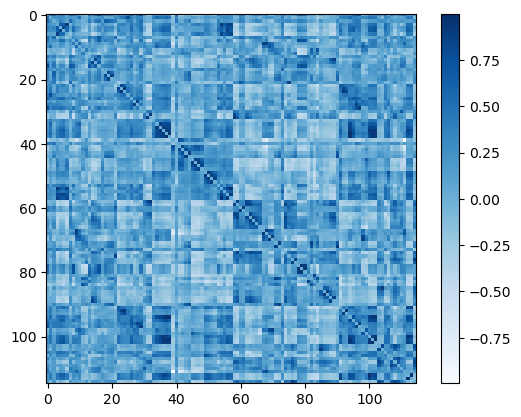

In [6]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrix_avg, cmap='Blues')
plt.colorbar()
plt.show()

### CC across trials for individual channel from the same subject.

For one particular channel (81), the ploted high CC means that this channel oscillate very stable across trials.


In [7]:
epoch=epoch3.copy().load_data().filter(l_freq=0.1,h_freq=3,picks=['eeg'])
data=epoch.get_data(picks=['eeg']) # (20, 115, 1001)
ch_number=data.shape[1]

In [8]:
matrixes=[]
ch_mean=[]
for ch in range(ch_number): # trial: (115, 1000)
    dataframe=pd.DataFrame(data=data[:,ch,:].squeeze().transpose())
    matrix = dataframe.corr(method='pearson').to_numpy()
    matrix[np.diag_indices_from(matrix)] = 0.
    matrixes.append(matrix)
    ch_mean.append(matrix.sum()/(20*20-20)) # diagonal is zero
matrix_avg=np.average(np.asarray(matrixes),axis=0) # 20*20

In [9]:
sum(ch_mean)/len(ch_mean)

0.15288299670780878

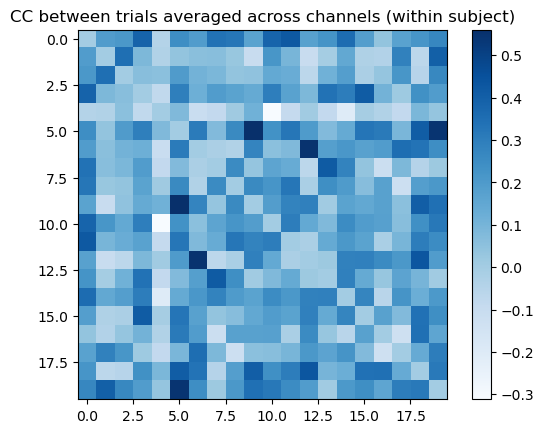

In [10]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrix_avg, cmap='Blues')
plt.title("CC between trials averaged across channels (within subject)")
plt.colorbar()
plt.show() 

# This plot actually meaningless, because each channel behavior very differently and this plot is the average across channels;
# This reconfirms that only few of them oscillates stable across trials.

In [23]:
roi_channels=sorted(range(len(ch_mean)), key=ch_mean.__getitem__) # ascending index
print(roi_channels)

[104, 103, 14, 90, 39, 30, 17, 111, 85, 68, 43, 87, 44, 41, 51, 47, 61, 114, 72, 7, 64, 52, 65, 67, 86, 42, 63, 77, 46, 89, 60, 107, 9, 88, 109, 33, 40, 81, 71, 108, 110, 93, 50, 76, 6, 21, 48, 15, 74, 75, 27, 19, 45, 92, 49, 59, 3, 24, 66, 23, 20, 113, 1, 62, 54, 2, 82, 96, 57, 28, 34, 55, 35, 97, 91, 18, 112, 83, 38, 25, 73, 106, 10, 100, 56, 4, 0, 36, 94, 37, 29, 58, 101, 12, 69, 102, 105, 22, 5, 13, 95, 26, 98, 70, 16, 31, 11, 99, 32, 53, 84, 8, 80, 79, 78]


In [14]:
check_this_channel=78

(array([29., 23., 21., 15., 11.,  6.,  6.,  0.,  2.,  2.]),
 array([-0.0467501 ,  0.02670504,  0.10016019,  0.17361534,  0.24707048,
         0.32052563,  0.39398078,  0.46743592,  0.54089107,  0.61434622,
         0.68780136]),
 <BarContainer object of 10 artists>)

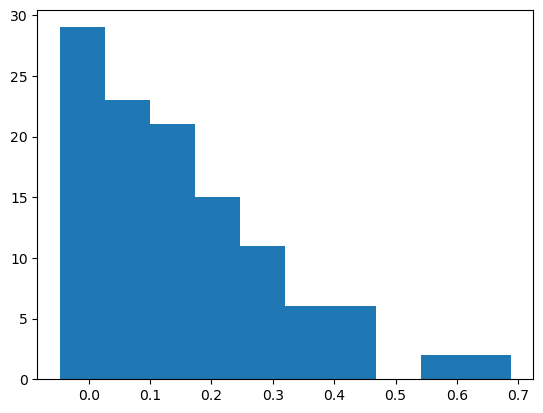

In [13]:
plt.hist(ch_mean)  # target 79,78 channels, both CCs > 0.6.

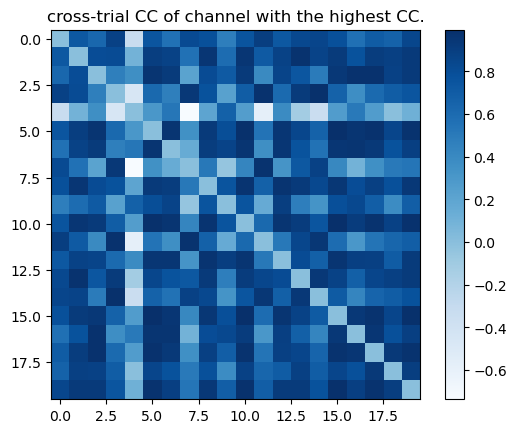

In [15]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrixes[check_this_channel], cmap='Blues')
plt.title("cross-trial CC of channel with the highest CC.")
plt.colorbar()
plt.show()

In [16]:
a=matrixes[check_this_channel].reshape(-1)
b=matrixes[check_this_channel].shape[0]
print('Mean CC: '+ str(sum(a)/(b*b-b)))

Mean CC: 0.6878013636526463


### Now, look at this 81th channel

In [17]:
tmin=-1
tmax=1
sf=1000
epochs=get_epoch_and_anat_label(sid, sf,tmin=tmin,tmax=tmax,trigger='EMG',re_ordered=True,random_shift=False)
#epochs=get_epoch(sid, sf,scaler='no',trigger='EMG',tmin=tmin,tmax=tmax)
epoch3=epochs['3'].load_data().pick(picks=[ch_names[check_this_channel], 'emg-0', 'emg-1', 'emg_diff', 'emg_diff_env','env_smooth_deriv',]) # simple grasp

Phase-locking.


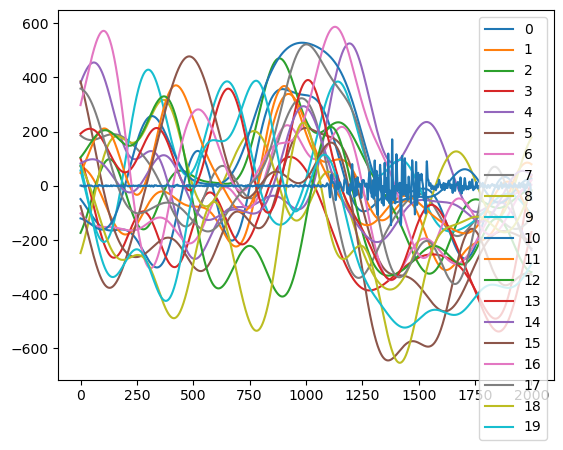

In [18]:
epoch=epoch3.copy().filter(l_freq=0.1,h_freq=3,picks=['eeg'])
data=epoch.get_data() #(20, 6, 501)

trial_num=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,]
for i in trial_num:
    plt.plot(data[i,0,:])
plt.plot(data[0,3,:]*0.1)
plt.legend([str(i) for i in trial_num])
print('Phase-locking.')

In [19]:
# check individual trials
%matplotlib qt
fig,ax=plt.subplots()
trial_num=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,]
for i in trial_num:
    ax.plot([j+i*600 for j in data[i,0,:]])
    ax.plot([j+i*600 for j in data[i,3,:]*0.2])
    
filename=data_dir+'/group_analysis/phase_locking_sid'+str(sid)+'.png'
fig.savefig(filename)
#fig.clear()
#plt.close(fig)
print('Phase-locking.')

Phase-locking.


The alignment is not perfect. A better method should be used:


![](img\8.png)

In [44]:
# channel name:
tmp=[ch_names[i].split('_')[1] for i in roi_channels[-20:]]
values, counts = np.unique(tmp, return_counts=True)
print([str(i)+'*'+str(j) for i,j in zip(values,counts)])
#1020: ctx-lh-parstriangularis; 1023:ctx-lh-posteriorcingulate; 1024:ctx-lh-precentral; 1027:ctx-lh-rostralmiddlefrontal; 1035:ctx-lh-insula; 3018:wm-lh-parsopercularis; 3023:wm-lh-posteriorcingulate; 3024: wm-lh-precentral;  3028: wm-lh-superiorfrontal;  3027: wm-lh-rostralmiddlefrontal; 3035:wm-lh-insula; 

['1020*1', '1023*1', '1024*3', '1027*2', '1035*2', '3018*1', '3023*1', '3024*4', '3027*1', '3028*3', '3035*1']


## check CC across subjects. CC with trigger='EMG' is much higher than CC with trigger='EEG', which means group analysis is possible.

In [4]:
from gesture.group_analysis.util import calculate_CC
import matplotlib.pyplot as plt

sid1=2
sid2=10
sf1=1000
sf2=1000

In [11]:
matrixes,ordered_ch_names=calculate_CC(sid1, sf1, sid2, sf2, f1=1, f2=3,trigger='EMG',re_ordered=True,duration=2)

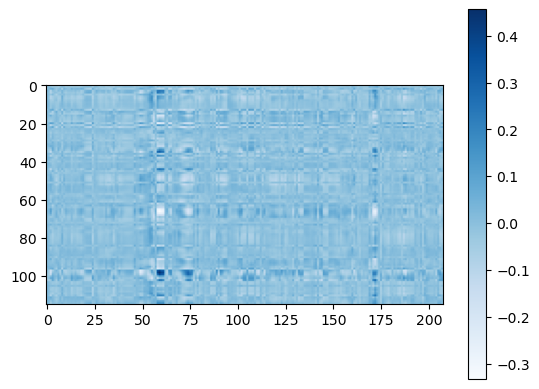

In [12]:
# trigger=EEG+random_shift
%matplotlib inline
fig,ax=plt.subplots()
im=ax.imshow(matrixes,cmap='Blues')
fig.colorbar(im)
plt.show() # 0.5s:0.35; 1s:0.35; sid2+10:[1s:0.55,2s:0.45]

In [13]:
matrixes,ordered_ch_names=calculate_CC(sid1, sf1, sid2, sf2, f1=1, f2=3,trigger='EEG',re_ordered=True,duration=2,random_shift=[500,1000])

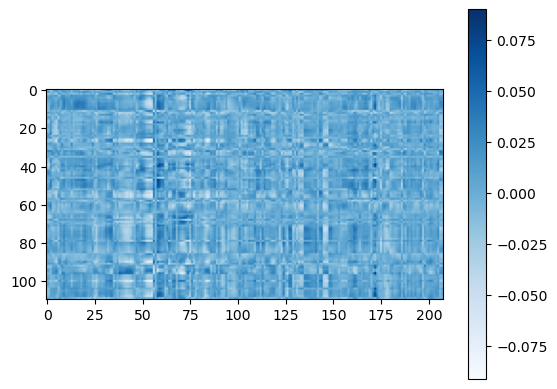

In [14]:
%matplotlib inline
# trigger=EMG
fig,ax=plt.subplots()
im=ax.imshow(matrixes,cmap='Blues')
fig.colorbar(im)
plt.show() # 0.07